# Прогнозы оттока клиентов для "Бета-Банка"

**Цель** - спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

**Задачи:**
  - Построить модель с предельно большим значением F1-меры
  - Как минимум нужно довести метрику до 0.59
  - Провести проверку F1-меры на тестовой выборке
  - Провести измерение AUC-ROC и сравнить её с F1-мерой

## Входные данные
Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

Признаки:
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — количество недвижимости у клиента
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак:
- `Exited` — факт ухода клиента

## Содержание <a id="contents">
1. Изучение входных данных
	- [Проверка на дубликаты](#dublicates)
	- [Проверка на пропуски](#omissions)
	- [Изучение данных кредитного рейтинга](#score)
	- [Изучение данных о балансе счета](#balance)
	- [Изучение данных о зарплате](#salary)
	- [Обработка данных о стране проживания и поле клиента](#country_gender)
	- [Проверка на отсутствие мультиколлинеарности между признаками](#corr)
	- [Проверка на соотношение классов в целевой переменной](#classes_ratio)


2. [Разделение данных на выборки и их стандартизация](#selection)

    
3.  Модели без учета дисбаланса классов
    - [3.1 Алгоритм логистической регрессии](#lr_simple)
	- [3.2 Алгоритм случайного леса](#rf_simple)
	- [3.3 Алгоритм решающего дерева](#dt_simple)
	- [3.4 Выводы](#conclusions_simple)
    
    
4. Исследование моделей
	- [4.1 Алгоритм логистической регрессии со взвешиванием классов](#lr_balance)
	- [4.2 Алгоритм случайного леса со взвешиванием классов](#rf_balance)
	- [4.3 Алгоритм решающего дерева](#dt_balance)
	- [4.4 Выводы](#conclusions_balance)


5. Модели с увеличенной выборкой
    - [5.1 Алгоритм логистической регрессии](#lr_upsampled)
	- [5.2 Алгоритм случайного леса](#rf_upsampled)
	- [5.3 Алгоритм решающего дерева](#dt_upsampled)
	- [5.4 Выводы](#conclusions_upsampled)

    
6. Модели с уменьшенной выборкой
    - [6.1 Алгоритм логистической регрессии](#lr_downsampled)
	- [6.2 Алгоритм случайного леса](#rf_downsampled)
	- [6.3 Алгоритм решающего дерева](#dt_downsampled)
	- [6.4 Выводы](#conclusions_downsampled)
    
    
7. Проверка лучшей F1 модели на тестовой выборке
    - [7.1 Сводная таблица](#pivot_f1)
    - [7.2 Проверка на тестовой выборке](#testing)


8. [Выводы](#summary)

## 1. Изучение входных данных
[вернуться к содержанию](#contents)

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.utils import shuffle
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
# sklearn.metrics import roc_curve

#from sklearn.dummy import DummyClassifier
#from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Markdown as md

In [2]:
path = ''
df = pd.read_csv(path + 'Churn.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


## Проверка на дубликаты  <a id="dublicates">

In [4]:
df.duplicated().sum()

0

- пропусков и дубликатов нет

## Проверка на пропуски <a id="omissions">

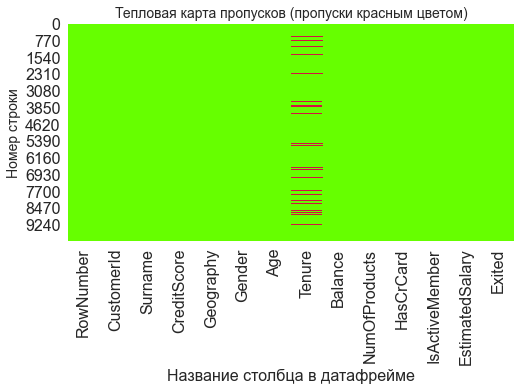

In [5]:
# тепловая карта, для общей визуализации количества пропусков
# зеленым цветом (#66ff00) - непропущенные, красным цветом (#d41243) - пропущенные данные 
colors = ['#66ff00', '#d41243'] 
fig, ax = plt.subplots(figsize=(8,4)) 
sns.heatmap(df.isna(), cmap=sns.color_palette(colors), cbar=False, ax=ax)
plt.xlabel('Название столбца в датафрейме', fontsize=16)
plt.ylabel('Номер строки', fontsize=14)
plt.title('Тепловая карта пропусков (пропуски красным цветом)', fontsize=14)
plt.show()

In [6]:
# на наличие NaN значений, в относительном выражении
df.isna().mean() 

RowNumber          0.0000
CustomerId         0.0000
Surname            0.0000
CreditScore        0.0000
Geography          0.0000
Gender             0.0000
Age                0.0000
Tenure             0.0909
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0000
IsActiveMember     0.0000
EstimatedSalary    0.0000
Exited             0.0000
dtype: float64

In [7]:
# на наличие пропусков как строковых значений
df.isin(['-', 'None', 'Null', ' ']).sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

- есть пропуски в `Tenure`, количестве объектов недвижимости у клиента, примерно ~10% от общего размера датасета
- чем заполнить непонятно, **удалим их** и переведем в целочисленный тип

In [8]:
df = df[df['Tenure'].notna()]
df['Tenure'] = df['Tenure'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9091 non-null   int64  
 1   CustomerId       9091 non-null   int64  
 2   Surname          9091 non-null   object 
 3   CreditScore      9091 non-null   int64  
 4   Geography        9091 non-null   object 
 5   Gender           9091 non-null   object 
 6   Age              9091 non-null   int64  
 7   Tenure           9091 non-null   int32  
 8   Balance          9091 non-null   float64
 9   NumOfProducts    9091 non-null   int64  
 10  HasCrCard        9091 non-null   int64  
 11  IsActiveMember   9091 non-null   int64  
 12  EstimatedSalary  9091 non-null   float64
 13  Exited           9091 non-null   int64  
dtypes: float64(2), int32(1), int64(8), object(3)
memory usage: 1.0+ MB


- удалим неинформативные столбцы: номер строки, фамилию, идентификатор

In [9]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Изучение данных кредитного рейтинга <a id="score">
[вернуться к содержанию](#contents)

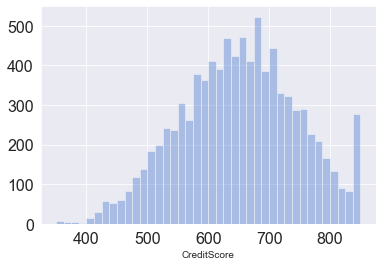

850    2.31
678    0.66
655    0.56
705    0.53
683    0.52
Name: CreditScore, dtype: float64

In [10]:
sns.distplot(df['CreditScore'], kde=False)
plt.show()
df['CreditScore'].value_counts(normalize=True).round(4).head() * 100

- в данных по кредитному рейтингу есть аномальный пик с клиентам с CreditScore = 850, 
- они занимеют 2.3% от общего размера данных, оставим как есть этих топовых клиентов

## Изучение данных о балансе счета <a id="balance">
[вернуться к содержанию](#contents)

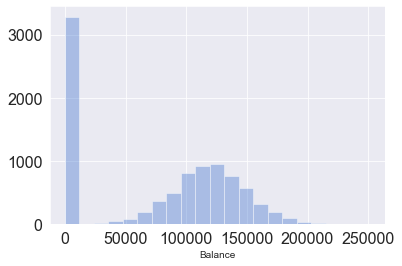

In [11]:
sns.distplot(df['Balance'], kde=False)
plt.show()

- в балансе много нулевых значений, скорее всего это просто неуказанные значения
- хочется заменить на медиану, но тогда сильно изменится вид распределения, оставим как есть

## Изучение данных о зарплате <a id="salary">
[вернуться к содержанию](#contents)

In [12]:
df['EstimatedSalary'] = df['EstimatedSalary'].round().astype('int')
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101349,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112543,0
2,502,France,Female,42,8,159660.80,3,1,0,113932,1
3,699,France,Female,39,1,0.00,2,0,0,93827,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084,0


## Обработка данных о стране проживания и поле клиента <a id="country_gender">
[вернуться к содержанию](#contents)
- проведем прямое кодирование так, чтобы не попасть в дамми-ловушку 

In [13]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101349,1,0,0,0
1,608,41,1,83807.86,1,0,1,112543,0,0,1,0
2,502,42,8,159660.80,3,1,0,113932,1,0,0,0
3,699,39,1,0.00,2,0,0,93827,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084,0,0,1,0


## Проверка на отсутствие мультиколлинеарности между признаками <a id="corr">
[вернуться к содержанию](#contents)

In [14]:
df.corr().style.background_gradient(cmap='Blues')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CreditScore,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,-0.023950,0.000428,0.001725,-0.008547
Age,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.283017,0.049038,-0.005622,-0.025631
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761,-0.003299,0.000810,0.012634
Balance,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.117218,0.401701,-0.136986,0.018030
NumOfProducts,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.050271,-0.009476,0.011903,-0.025176
HasCrCard,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,-0.005411,0.009149,-0.017779,0.006016
IsActiveMember,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.155062,-0.016821,0.014800,0.025019
EstimatedSalary,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.016030,0.011551,-0.010998,-0.002658
Exited,-0.023950,0.283017,-0.016761,0.117218,-0.050271,-0.005411,-0.155062,0.016030,1.000000,0.178131,-0.055971,-0.110450
Geography_Germany,0.000428,0.049038,-0.003299,0.401701,-0.009476,0.009149,-0.016821,0.011551,0.178131,1.000000,-0.332879,-0.023701


## Проверка на соотношение классов в целевой переменной <a id="classes_ratio">
[вернуться к содержанию](#contents)

In [15]:
(df.Exited.value_counts()
            .reset_index()
            .style.bar(subset=['Exited'], color='#67A5EB', align='mid')
            .set_caption('Распределение классов в целевом признаке:')
            .hide_index()
            .set_table_styles([{'selector': 'caption', 
                             'props': [('color', 'blue'), ('font-size', '15px')]}])
)

index,Exited
0,7237
1,1854


In [16]:
# соотношение класса "0" к классу "1" в целевой переменной
classes_ratio = df.Exited.value_counts()[0] / df.Exited.value_counts()[1] 
md('**Отношение класса "0" к классу "1" составляет**:  {:.2f}'.format(classes_ratio))

**Отношение класса "0" к классу "1" составляет**:  3.90

- Баланса нет, поэтому ниже пойдем тремя дорогами:
  - добавим веса для редким положительным объектам
  - увеличим выборку, сделав upsampling для положительных объектов
  - уменьшим выборку, сделав downsampling для отрицательных объектов
  
  
- Для сравнения метрик также построим модели без учета дисбаланса классов.

## Разделение данных на выборки и их стандартизация <a id="selection">
[вернуться к содержанию](#contents)

In [17]:
# разобъем на признаки и целевую переменную
target = df['Exited']
features = df.drop('Exited', axis=1)

In [18]:
# выделяем тестовую выборку в размере 20% от исходного датасета
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                    test_size=0.2, 
                                                    random_state=12345,
                                                    stratify = target)

In [19]:
# из обучающей выделяем валидационную 
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, 
                                                  test_size=0.25, 
                                                  random_state=12345) 

print('''Размер обучающей выборки: {:.1%}
Размер валидационной: {:.1%}
Размер тестовой: {:.1%}'''.format(features_train.shape[0]/df.shape[0], 
                                  features_test.shape[0]/df.shape[0], 
                                  features_valid.shape[0]/df.shape[0]))

Размер обучающей выборки: 60.0%
Размер валидационной: 20.0%
Размер тестовой: 20.0%


#### Проверям соотношение класса "1" к классу "0" в сформированных обучающей, валидационной, тестовой выборках

In [20]:
for target_i in [target_train, target_valid, target_test]:
    print(target_i.value_counts())
    print('доля класса "1": {:.2%}'.format(target_i.value_counts()[1] / target_i.value_counts()[0]))
    print('-----------------------------')

0    4376
1    1078
Name: Exited, dtype: int64
доля класса "1": 24.63%
-----------------------------
0    1413
1     405
Name: Exited, dtype: int64
доля класса "1": 28.66%
-----------------------------
0    1448
1     371
Name: Exited, dtype: int64
доля класса "1": 25.62%
-----------------------------


In [21]:
# проведем стандартизацию количественных переменных
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# пример данных после стандартизации
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9665,-1.080178,-0.839008,0.345342,-1.215169,0.810398,1,1,-1.397452,0,0,1
8662,-1.463449,0.492039,-0.341188,0.753595,-0.914782,1,0,-1.223716,1,0,0
2484,2.058502,0.016665,0.345342,0.334349,-0.914782,1,1,0.397633,0,0,1
5107,2.027426,-0.173485,1.375135,0.587886,-0.914782,1,0,0.300512,0,1,0
7717,0.421830,0.682189,-1.027717,-1.215169,0.810398,1,1,0.124602,0,1,1


## 3. Исследование моделей
[вернуться к содержанию](#contents)

In [22]:
def my_lr_model(features_for_training, 
                target_for_training, 
                features_for_valid, 
                target_for_valid, 
                class_weight):
    """Задает алгоритм логистической регрессии с возможностью взвесить классы"""
    threshold_list = []
    f1_score_list = []
    roc_auc_list = []
    # сделаем прогноз с разными порогами
    for threshold in np.arange(0, 1, 0.02):
        lr_model = LogisticRegression(random_state=12345, 
                                      solver='liblinear', 
                                      class_weight=class_weight)
        lr_model.fit(features_for_training, target_for_training)
        # воспользуемся уже обученной моделью, чтобы определить вероятности для "0" и "1"
        probabilities_valid = lr_model.predict_proba(features_for_valid)
        # вероятности для класса "1"
        probabilities_one_valid = probabilities_valid[:, 1]
        # откорректируем прогноз по порогу   
        predicted_valid = np.where(probabilities_one_valid > threshold, 1, 0)
        f1 = f1_score(target_for_valid, predicted_valid)
        roc_auc = roc_auc_score(target_for_valid, probabilities_one_valid)
        # сохраним значения метрик 
        threshold_list.append(threshold)
        f1_score_list.append(f1)
        roc_auc_list.append(roc_auc)
        lr_model_result = pd.DataFrame({'threshold':threshold_list, 
                               'f1_value':f1_score_list, 
                               'roc_auc_value':roc_auc_list})
        
    # посмотрим графически
    ax = lr_model_result.plot(x="threshold", y="f1_value", legend=False, marker='.', linestyle='', color='b')
    ax2 = ax.twinx()
    lr_model_result.plot(x="threshold", y="roc_auc_value", ax=ax2, legend=False, marker='.', linestyle='-', color='g')
    ax.figure.legend(loc='center', fontsize=16)
    plt.show()
    
    display(lr_model_result
     .sort_values(by='f1_value', ascending=False)
     .head()
     .style
     .format('{:.3f}', subset=['f1_value', 'roc_auc_value'])
     .highlight_max(subset=['f1_value', 'roc_auc_value'])
    )

In [23]:
def my_rf_model(features_for_training, 
                target_for_training, 
                features_for_valid, 
                target_for_valid, 
                class_weight):
    """Задает алгоритм случайного леса с возможностью взвесить классы"""
    n_estim_list = []
    f1_score_list = []
    roc_auc_list = []
    for n in range(1, 51):
        rf_model = RandomForestClassifier(n_estimators=n, 
                                          random_state=12345, 
                                          class_weight=class_weight)
        rf_model.fit(features_for_training, target_for_training)
        predicted_valid = rf_model.predict(features_for_valid)
        f1 = f1_score(target_for_valid, predicted_valid)
        probabilities_valid = rf_model.predict_proba(features_for_valid)    
        roc_auc = roc_auc_score(target_for_valid, probabilities_valid[:, 1])
        n_estim_list.append(n)
        f1_score_list.append(f1)
        roc_auc_list.append(roc_auc)
        rf_model_result = pd.DataFrame({'n_estim_value':n_estim_list, 
                               'f1_value':f1_score_list, 
                               'roc_auc_value':roc_auc_list})
        
    # посмотрим графически
    ax = rf_model_result.plot(x="n_estim_value", y="f1_value", legend=False, marker='.', linestyle='', color='b')
    ax2 = ax.twinx()
    rf_model_result.plot(x="n_estim_value", y="roc_auc_value", ax=ax2, legend=False, marker='.', linestyle='-', color='g')
    ax.figure.legend(loc='center', fontsize=16)
    plt.show()    
 
    display(rf_model_result
     .sort_values(by='f1_value', ascending=False)
     .head()
     .style
     .format('{:.3f}', subset=['f1_value', 'roc_auc_value'])
     .highlight_max(subset=['f1_value', 'roc_auc_value'])
    )

In [24]:
def my_dt_model(features_for_training, 
                target_for_training, 
                features_for_valid, 
                target_for_valid,
                class_weight):
    """Задает алгоритм решающего дерева разной глубины"""
    depth_list = []
    f1_score_list = []
    roc_auc_list = []
    for depth in range(1, 20):
        dt_model = DecisionTreeClassifier(random_state=12345, 
                                          max_depth=depth, 
                                          class_weight=class_weight)
        dt_model.fit(features_for_training, target_for_training)
        predicted_valid = dt_model.predict(features_for_valid)
        f1 = f1_score(target_for_valid, predicted_valid)
        probabilities_valid = dt_model.predict_proba(features_for_valid)    
        roc_auc = roc_auc_score(target_for_valid, probabilities_valid[:, 1])
        depth_list.append(depth)
        f1_score_list.append(f1)
        roc_auc_list.append(roc_auc)
        dt_model_result = pd.DataFrame({'depth_value':depth_list, 
                               'f1_value':f1_score_list, 
                               'roc_auc_value':roc_auc_list})
        
    # посмотрим графически
    ax = dt_model_result.plot(x="depth_value", y="f1_value", legend=False, marker='.', linestyle='-', color='b')
    ax2 = ax.twinx()
    dt_model_result.plot(x="depth_value", y="roc_auc_value", ax=ax2, legend=False, marker='.', linestyle='-', color='g')
    ax.figure.legend(loc='center', fontsize=16)
    plt.show()

    display(dt_model_result
     .sort_values(by='f1_value', ascending=False)
     .head()
     .style
     .format('{:.3f}', subset=['f1_value', 'roc_auc_value'])
     .highlight_max(subset=['f1_value', 'roc_auc_value'])
    )

## 3. Модели без учета дисбаланса классов

## 3.1 Алгоритм логистической регрессии <a id="lr_simple">
[вернуться к содержанию](#contents)

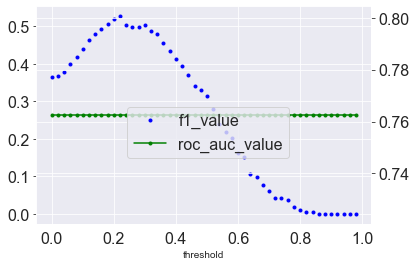

,threshold,f1_value,roc_auc_value
11,0.220000,0.527,0.762
10,0.200000,0.520,0.762
9,0.180000,0.507,0.762
12,0.240000,0.504,0.762
15,0.300000,0.502,0.762


In [25]:
my_lr_model(features_train,   # берем обучающую выборку с дисбалансом
            target_train, 
            features_valid, 
            target_valid, 
            class_weight=None) # не взвешиваем классы, берем данные "как есть"

## 3.2 Алгоритм случайного леса <a id="rf_simple">
[вернуться к содержанию](#contents)

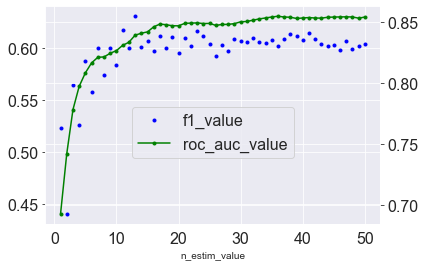

,n_estim_value,f1_value,roc_auc_value
12,13,0.631,0.839
10,11,0.618,0.831
22,23,0.617,0.850
40,41,0.614,0.854
37,38,0.614,0.854


In [26]:
my_rf_model(features_train,    # берем обучающую выборку с дисбалансом
            target_train, 
            features_valid, 
            target_valid, 
            class_weight=None) # не взвешиваем классы, берем данные "как есть"

## 3.3 Алгоритм решающего дерева <a id="dt_simple">
[вернуться к содержанию](#contents)

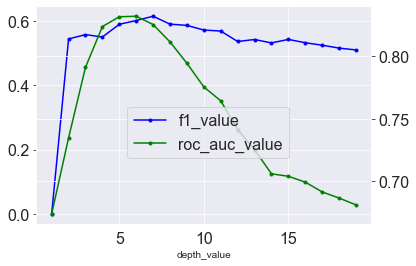

,depth_value,f1_value,roc_auc_value
6,7,0.615,0.825
5,6,0.601,0.832
7,8,0.590,0.811
4,5,0.590,0.832
8,9,0.586,0.794


In [27]:
my_dt_model(features_train,    # берем обучающую выборку с дисбалансом
            target_train, 
            features_valid, 
            target_valid, 
            class_weight=None) # не взвешиваем классы, берем данные "как есть"

## 3.4 Выводы для простых моделей <a id="conclusions_simple">
    
  - наибольший F1 равен 0.527 для логистической регрессии при пороге в 0.22
  - наибольший F1 равен 0.631 для случайного леса при n=13
  - наибольший F1 равен 0.615 для решающего дерева с глубиной depth=7

## 4. Модели со взвешиванием классов

## 4.1 Алгоритм логистической регрессии со взвешиванием классов <a id="lr_balance">
[вернуться к содержанию](#contents)

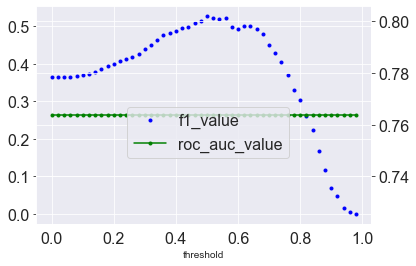

,threshold,f1_value,roc_auc_value
25,0.500000,0.527,0.764
26,0.520000,0.523,0.764
28,0.560000,0.521,0.764
27,0.540000,0.519,0.764
24,0.480000,0.515,0.764


In [28]:
my_lr_model(features_train, 
            target_train, 
            features_valid, 
            target_valid, 
            class_weight='balanced')

## 4.2 Алгоритм случайного леса со взвешиванием классов <a id="rf_balance">
[вернуться к содержанию](#contents)

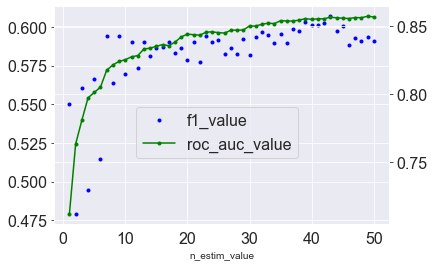

,n_estim_value,f1_value,roc_auc_value
42,43,0.607,0.856
38,39,0.603,0.855
41,42,0.603,0.855
39,40,0.601,0.855
40,41,0.601,0.855


In [29]:
my_rf_model(features_train, 
            target_train, 
            features_valid, 
            target_valid, 
            class_weight='balanced')

## 4.3 Алгоритм решающего дерева <a id="dt_balance">
[вернуться к содержанию](#contents)

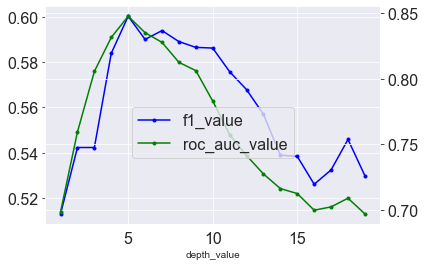

,depth_value,f1_value,roc_auc_value
4,5,0.600,0.848
6,7,0.594,0.828
5,6,0.590,0.835
7,8,0.589,0.812
8,9,0.586,0.806


In [30]:
my_dt_model(features_train, 
            target_train, 
            features_valid, 
            target_valid, 
            class_weight='balanced')

## 4.4 Выводы для взвешенной выборки<a id="conclusions_balance">
[вернуться к содержанию](#contents)
  - наибольший F1 равен 0.527 для логистической регрессии при пороге в 0.50
  - наибольший F1 равен 0.609 для случайного леса при n=11
  - наибольший F1 равен 0.600 для решающего дерева с глубиной depth=5

## 5. Модели с увеличенной выборкой
[вернуться к содержанию]

In [31]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # увеличиваем размер класса "1" на заданный коэфициент
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # премешиваем, т.к. идущие друг за другом одинаковые вопросы не помогут обучению
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [32]:
# применяем функцию, число repeat равно исходному соотношению классов в целевой переменной
features_upsampled, target_upsampled = upsample(features_train, target_train, repeat=int(classes_ratio.round(0)))

print('Исходное соотношение классов в target_train: ', target_train.value_counts(), sep='\n')
print('--------------------------------------------------------')
print('Cоотношение классов в target_upsampled: ', target_upsampled.value_counts(), sep='\n')

Исходное соотношение классов в target_train: 
0    4376
1    1078
Name: Exited, dtype: int64
--------------------------------------------------------
Cоотношение классов в target_upsampled: 
0    4376
1    4312
Name: Exited, dtype: int64


## 5.1 Алгоритм логистической регрессии <a id="lr_upsampled">
[вернуться к содержанию](#contents)

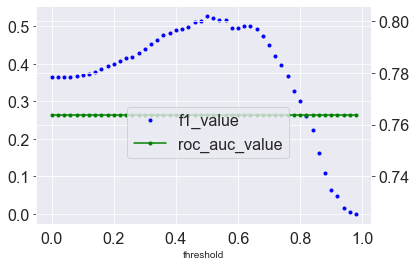

,threshold,f1_value,roc_auc_value
25,0.500000,0.527,0.764
26,0.520000,0.523,0.764
27,0.540000,0.518,0.764
28,0.560000,0.518,0.764
24,0.480000,0.513,0.764


In [33]:
my_lr_model(features_upsampled, 
            target_upsampled, 
            features_valid, 
            target_valid, 
            class_weight=None)

## 5.2 Алгоритм случайного леса <a id="rf_upsampled">
[вернуться к содержанию](#contents)

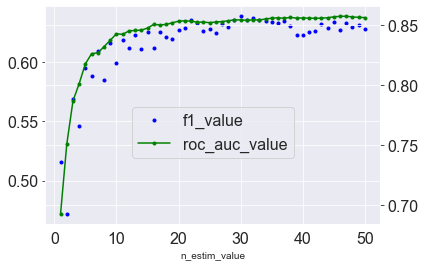

,n_estim_value,f1_value,roc_auc_value
29,30,0.639,0.854
31,32,0.637,0.854
21,22,0.636,0.853
28,29,0.636,0.854
30,31,0.636,0.854


In [34]:
my_rf_model(features_upsampled, 
            target_upsampled, 
            features_valid, 
            target_valid, 
            class_weight=None)

## 5.3 Алгоритм решающего дерева <a id="dt_upsampled">
[вернуться к содержанию](#contents)

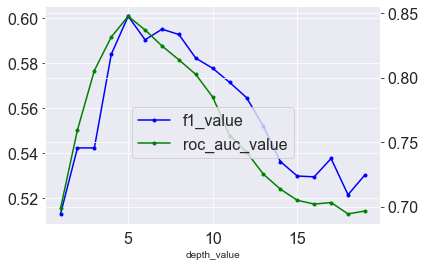

,depth_value,f1_value,roc_auc_value
4,5,0.601,0.848
6,7,0.595,0.825
7,8,0.593,0.814
5,6,0.590,0.837
3,4,0.584,0.831


In [35]:
my_dt_model(features_upsampled, 
            target_upsampled, 
            features_valid, 
            target_valid, 
            class_weight=None)

## 5.4 Выводы для увеличенной выборки <a id="conclusions_upsampled">
[вернуться к содержанию](#contents)
  - наибольший F1 равен 0.527 для логистической регрессии при пороге в 0.50
  - наибольший F1 равен 0.639 для случайного леса при n=30
  - наибольший F1 равен 0.601 для решающего дерева с глубиной depth=5

## 6. Модели с уменьшенной выборкой
[вернуться к содержанию](#contents)

In [36]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # уменьшаем размер класса "0" на заданный коэфициент выбросыванием из таблицы случайных элементов
    features_downsampled = pd.concat(
                [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
                [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    # премешиваем, т.к. идущие друг за другом одинаковые вопросы не помогут обучению
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [37]:
# применяем функцию, число repeat равно исходному соотношению классов в целевой переменной
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print('Исходное соотношение классов в target_train:', target_train.value_counts(), sep='\n')
print('--------------------------------------------------------')
print('Cоотношение классов в target_downsampled:', target_downsampled.value_counts(), sep='\n')

Исходное соотношение классов в target_train:
0    4376
1    1078
Name: Exited, dtype: int64
--------------------------------------------------------
Cоотношение классов в target_downsampled:
0    1094
1    1078
Name: Exited, dtype: int64


## 6.1 Алгоритм логистической регрессии <a id="lr_downsampled">
[вернуться к содержанию](#contents)

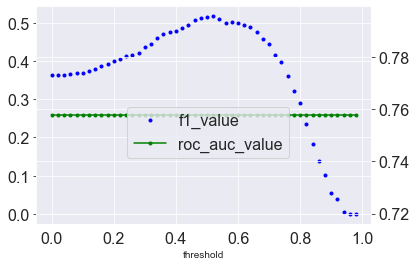

,threshold,f1_value,roc_auc_value
26,0.520000,0.517,0.758
25,0.500000,0.514,0.758
24,0.480000,0.512,0.758
27,0.540000,0.509,0.758
23,0.460000,0.507,0.758


In [38]:
my_lr_model(features_downsampled, 
            target_downsampled, 
            features_valid, 
            target_valid, 
            class_weight=None)

## 6.2 Алгоритм случайного леса <a id="rf_downsampled">
[вернуться к содержанию](#contents)

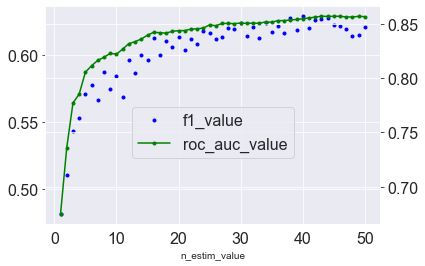

,n_estim_value,f1_value,roc_auc_value
39,40,0.629,0.855
43,44,0.628,0.857
37,38,0.628,0.853
42,43,0.627,0.857
41,42,0.626,0.856


In [39]:
my_rf_model(features_downsampled, 
            target_downsampled, 
            features_valid, 
            target_valid, 
            class_weight=None)

## 6.3 Алгоритм решающего дерева <a id="dt_downsampled">
[вернуться к содержанию](#contents)

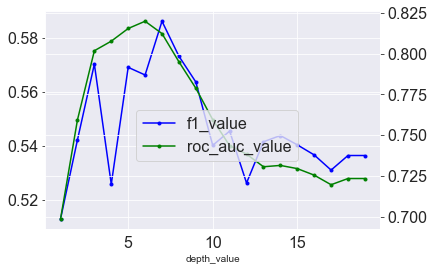

,depth_value,f1_value,roc_auc_value
6,7,0.586,0.812
7,8,0.573,0.795
2,3,0.570,0.802
4,5,0.569,0.816
5,6,0.566,0.820


In [40]:
my_dt_model(features_downsampled, 
            target_downsampled, 
            features_valid, 
            target_valid, 
            class_weight=None)

## 6.4 Выводы для уменьшенной выборки <a id="conclusions_downsampled">
  - наибольший F1 равен 0.517 для логистической регрессии при пороге в 0.52
  - наибольший F1 равен 0.629 для случайного леса при n=40
  - наибольший F1 равен 0.586 для решающего дерева с глубиной depth=7

## 7. Проверка лучшей F1 модели на тестовой выборке
[вернуться к содержанию](#contents)

## 7.1 Сводная таблица <a id="pivot_f1">

<table width="100%" border="1" cellpadding="4" cellspacing="0">
   <caption>Значение F1 метрики </caption>
    <tr>
        <td> <b>Model type </td>
        <td> <b>Disbalanced classed</td>
        <td> <b>Balanced classed </td>
        <td> <b>Upsampled class "1" </td>
        <td> <b>Downsampled class "0" </td>
    </tr>
    <tr>
        <td> <b>Logistic regression </td>
        <td> 0.527 </td>
        <td> 0.527 </td>
        <td> 0.527</td>
        <td> 0.517</td>
    </tr>
    <tr>
        <td> <b>Random Forest </td>
        <td> 0.631 </td>
        <td> 0.609</td>
        <td> <b>0.639</td>
        <td> 0.629</td>
    </tr>
    <tr>
        <td> <b> Decision Tree </td>
        <td> 0.615 </td>
        <td> 0.600</td>
        <td> 0.601</td>
        <td> 0.586</td>
    </tr>
</table>

#### Лучшей является модель на основе алгоритма `Random Forest` с `upsampled` выборкой c `n_est = 30`

## 7.2 Проверка на тестовой выборке <a id="testing">

In [41]:
rf_model = RandomForestClassifier(n_estimators=30, 
                                  random_state=12345, 
                                  class_weight=None)

rf_model.fit(features_upsampled, target_upsampled)

# делаем прогноз для тестовой выборки
predicted_test = rf_model.predict(features_test)
probabilities_test = rf_model.predict_proba(features_test) 

f1 = f1_score(target_test, predicted_test)
roc_auc = roc_auc_score(target_test, probabilities_test[:, 1])

md('**На тестовой выборке: метрика F1 - {}, метрика roc_auc - {}**'.format(round(f1, 2), round(roc_auc, 2)))

**На тестовой выборке: метрика F1 - 0.61, метрика roc_auc - 0.84**

fpr: [0.         0.         0.00138122 0.00345304 0.00552486 0.00759669
 0.01174033 0.01381215 0.01588398 0.01933702 0.02762431 0.03245856
 0.04005525 0.04903315 0.06146409 0.0718232  0.08287293 0.10428177
 0.12154696 0.14088398 0.16781768 0.1961326  0.23756906 0.27417127
 0.31975138 0.36809392 0.43439227 0.51243094 0.59668508 0.69958564
 0.83218232 1.        ]
tpr: [0.         0.01886792 0.03773585 0.0754717  0.12398922 0.16981132
 0.22102426 0.26954178 0.32345013 0.37196765 0.39622642 0.42587601
 0.47169811 0.50134771 0.52830189 0.5606469  0.59299191 0.61994609
 0.64420485 0.67115903 0.69541779 0.71698113 0.7574124  0.79245283
 0.82210243 0.85175202 0.87331536 0.89757412 0.94339623 0.95956873
 0.98382749 1.        ]
roc_auc_score:  0.8433921311670711


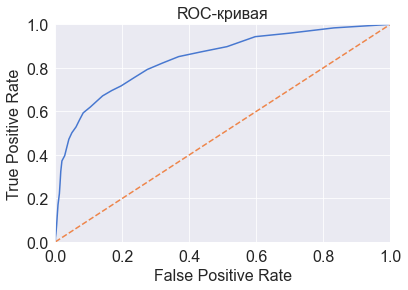

In [42]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test[:, 1]) 

print('fpr:', fpr)
print('tpr:', tpr)
print('roc_auc_score: ', roc_auc_score(target_test, probabilities_test[:, 1]))


plt.figure()
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC-кривая', fontsize=16)
plt.show()

## 8. Выводы <a id="summary">
[вернуться к содержанию](#contents)
    
Наилучшей моделью с точки зрения F1 метрики является модель на основе алгоритма `Random Forest` с `upsampled` выборкой c гиперпараметром `n_est = 30`. Она демонстрирует F1 = 0.64 на валидационной и F1 = 0.61 на тестовой выборках, соответственно. При этом значение roc_auc метрики находится в пределах 0.84-0.86.